# Topics - Easy Topic Modeling in Python

## 1. Preprocessing

### 1.1. Preperations

#### Loading modules from DARIAH-Topics library

In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import mallet as mal
from dariah_topics import evaluation

#### Load required functions from Gensim

In [2]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

#### Activating inline output in Jupyter notebook

In [3]:
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/traitlets/traitlets.py:809: DeprecationWarning: A parent of InlineBackend._config_changed has adopted the new (traitlets 4.1) @observe(change) API
  clsname, change_or_name), DeprecationWarning)
/usr/lib/python3.4/importlib/_bootstrap.py:321: DeprecationWarning: `IPython.lib.inputhook` is deprecated since IPython 5.0 and will be removed in future versions.
  return f(*args, **kwds)
/usr/local/lib/python3.4/dist-packages/IPython/lib/inputhook.py:327: DeprecationWarning: `register` is deprecated since IPython 5.0 and will be removed in future versions.
  @inputhook_manager.register('osx')
/usr/local/lib/python3.4/dist-packages/IPython/lib/inputhook.py:336: DeprecationWarning: `register` is deprecated since IPython 5.0 and will be removed in future versions.
  @inputhook_manager.register('wx')
/usr/local/lib/python3.4/dist-packages/IPython/lib/inputhook.py:398: DeprecationWarning: `register` is deprecated since IPython 5.0 and will be removed in futu

### 1.2. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using a folder of 'txt' documents provided with the package.

In [4]:
path = "corpus_txt"

#### List all documents in the folder

In [5]:
# List documents in folder
doclist = pre.create_document_list(path)

Let us check the list of documents:

In [6]:
doclist

['corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Howard_ShadowsintheMoonlight.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt',
 'corpus_txt/Howard_SchadowsinZamboula.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Kipling_TheJungleBook.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt']

#### Generate document labels

In [7]:
doc_labels = list(pre.get_labels(doclist))

#### Read listed documents from folder

The list of documents can also be manipulated before giving it to the following function to select specific documents from the folder. In the general case shown here, all documents in the folder are read.

In [8]:
corpus = pre.read_from_txt(doclist)

At this point, the corpus is generator object.

### 1.3. Tokenize corpus

In [9]:
doc_tokens = [list(pre.tokenize(doc)) for doc in list(corpus)]

### 1.4. Create a sparse bag-of-words model

The LDA topic model is based on a bag-of-words model of the corpus. To improve performance in large corpora, actual words and document titels are replaced by indices in the actual bag-of-words model. It is therefore necessary to create dictionaries for mapping these indices in advance.

#### Create dictionaries

In [10]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Create market matrix

In [11]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

### 1.5. Feature selection and/or removal

In topic modeling, it is often usefull (if not vital) to remove some types before modeling. In this example, the 100 most frequent words and the hapax legomena in the corpus are listed and removed. Alternatively, the 'feature_list' containing all features that are to be removed from the corpus can be replaced by, or combined with a simple stop word list.

#### List the 100 most frequent words

In [12]:
mfw100 = pre.find_stopwords(sparse_bow, id_types, 100)

#### List hapax legomena

In [13]:
hapax_list = pre.find_hapax(sparse_bow, id_types)

#### Combine lists and remove content from bag-of-words model

In [14]:
feature_list = set(mfw100).union(hapax_list)
clean_term_frequency = pre.remove_features(sparse_bow, id_types, feature_list)

### 1.6. Save bag-of-words model

In [15]:
pre.save_bow_mm(sparse_bow)

## 2. Model creation

The actual topic modeling is done with external state-of-the art LDA implementations. In this example, we are relying on Gensim.

### 2.1. Load corpus object

In [16]:
mm = MmCorpus("gb_plain.mm")

### 2.2. Rearrange dictionaries 

In [17]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

### 2.3. Generate LDA model

**Warning: this step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of passes. Our example short stories corpus should be done within a minute or two at 'passes = 10'.

In [18]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=10, passes = 10)

### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results.

In [19]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

## 3. Model visualization and evaluation

### 3.1. The document-topic matrix in a heat map

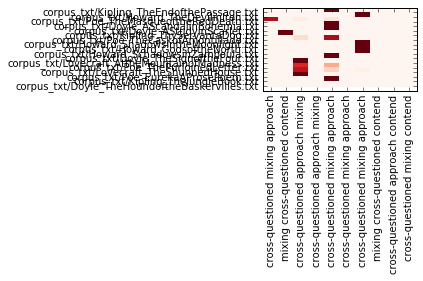

In [20]:
heatmap = visual.doc_topic_heatmap(doc_topic)
heatmap.show()

### 3.2. Topics in a single document

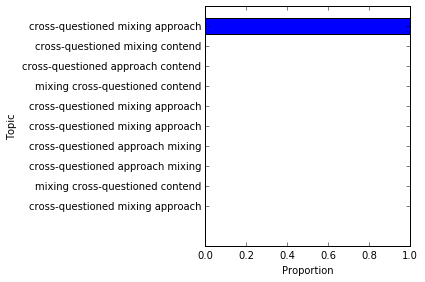

In [21]:
visual.plot_doc_topics(doc_topic, 0)